## Miniproject 2: MovieLens Visualization



### Download data

In [2]:
import requests

url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [3]:
import pandas as pd

data = pd.read_csv('data.csv')
movies = pd.read_csv('movies.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

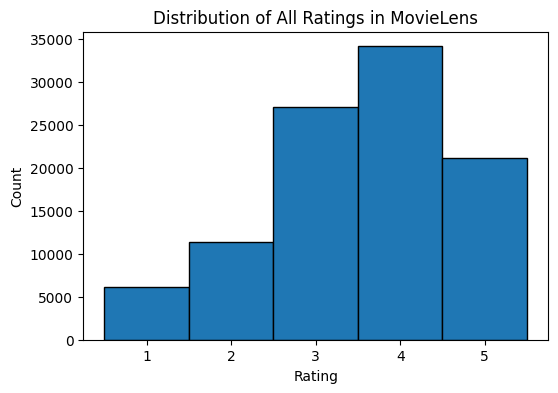

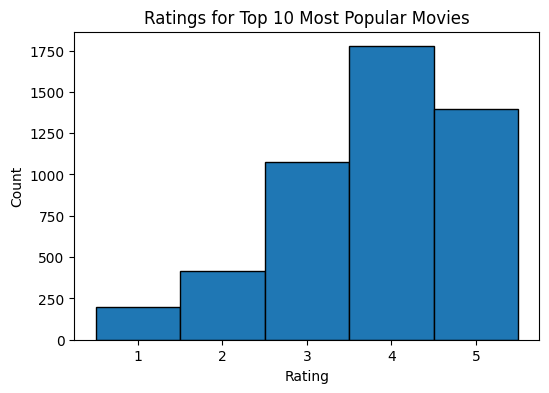

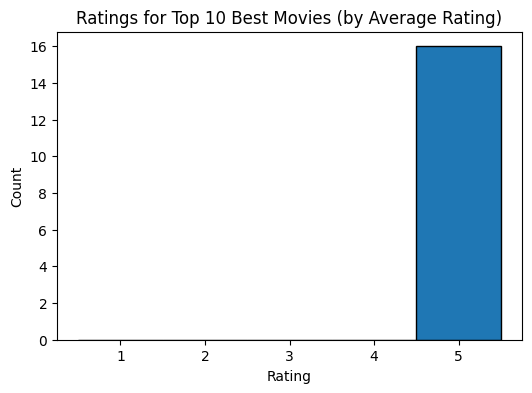

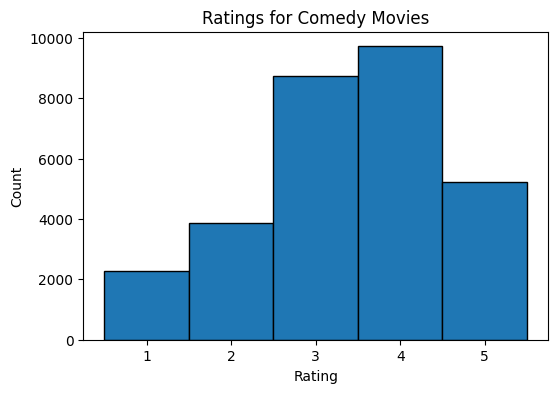

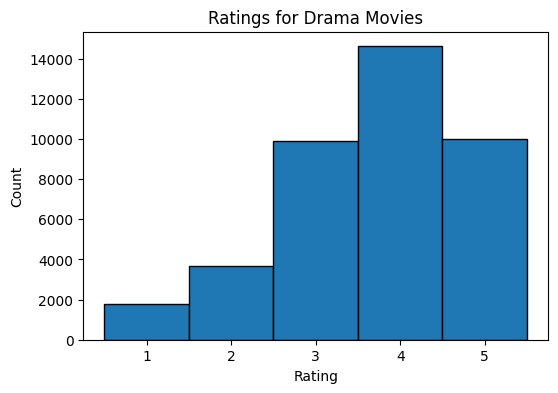

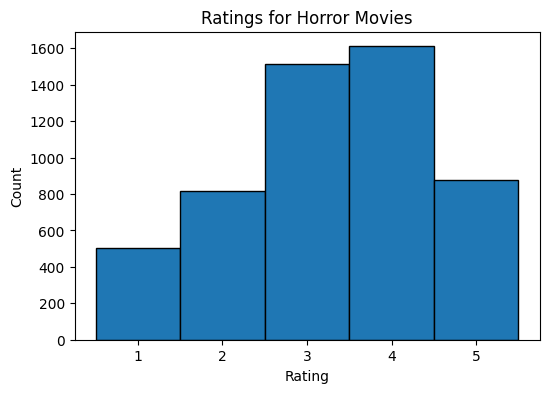

In [4]:
import matplotlib.pyplot as plt

# 1) All ratings in the MovieLens dataset
plt.figure(figsize=(6,4))
plt.hist(data['Rating'], bins=range(1,7), align='left', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of All Ratings in MovieLens')
plt.show()

# 2) All ratings of the ten most popular movies (by total number of ratings)
rating_counts = data.groupby('Movie ID')['Rating'].count()
top10_popular_ids = rating_counts.sort_values(ascending=False).head(10).index

top10_popular_ratings = data[data['Movie ID'].isin(top10_popular_ids)]

plt.figure(figsize=(6,4))
plt.hist(top10_popular_ratings['Rating'], bins=range(1,7), align='left', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Ratings for Top 10 Most Popular Movies')
plt.show()

# 3) All ratings of the ten best movies (highest average rating)
avg_ratings = data.groupby('Movie ID')['Rating'].mean()
top10_best_ids = avg_ratings.sort_values(ascending=False).head(10).index

top10_best_ratings = data[data['Movie ID'].isin(top10_best_ids)]

plt.figure(figsize=(6,4))
plt.hist(top10_best_ratings['Rating'], bins=range(1,7), align='left', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Ratings for Top 10 Best Movies (by Average Rating)')
plt.show()

# 4) All ratings of movies from three genres of your choice
#    Suppose we pick "Comedy", "Drama", and "Horror" for example

chosen_genres = ['Comedy', 'Drama', 'Horror']

for genre in chosen_genres:
    # Find Movie IDs that belong to this genre:
    genre_movie_ids = movies[movies[genre] == 1]['Movie ID']
    
    # Filter ratings for just those movies:
    genre_ratings = data[data['Movie ID'].isin(genre_movie_ids)]
    
    # Plot histogram:
    plt.figure(figsize=(6,4))
    plt.hist(genre_ratings['Rating'], bins=range(1,7), align='left', edgecolor='black')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title(f'Ratings for {genre} Movies')
    plt.show()


In [5]:
import numpy as np
import pandas as pd
import random

# Existing gradient and error functions
def grad_U(Ui, Yij, Vj, reg, eta):
    return eta * (reg * Ui - Vj * (Yij - np.dot(Ui, Vj)))

def grad_V(Vj, Yij, Ui, reg, eta):
    return eta * (reg * Vj - Ui * (Yij - np.dot(Ui, Vj)))

def get_err(U, V, Y, reg=0.0):
    err = 0
    for (i, j, Y_ij) in Y:
        err += 0.5 * (Y_ij - np.dot(U[i-1], V[j-1]))**2
    err += 0.5 * reg * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2)
    return err / len(Y)

def train_model(M, N, K, eta, reg, Y_train, max_epochs=100, eps=0.0001):
    """
    M = #users, N = #movies, K = latent dimension
    eta = learning rate, reg = regularization
    Y_train = list of (i, j, rating)
    """
    # Initialize U, V
    U = np.random.uniform(-0.5, 0.5, size=(M, K))
    V = np.random.uniform(-0.5, 0.5, size=(N, K))

    first_err = get_err(U, V, Y_train, reg)
    reduction = 0

    for epoch in range(max_epochs):
        np.random.shuffle(Y_train)

        for (i, j, Y_ij) in Y_train:
            U[i-1] -= grad_U(U[i-1], Y_ij, V[j-1], reg, eta)
            V[j-1] -= grad_V(V[j-1], Y_ij, U[i-1], reg, eta)

        current_err = get_err(U, V, Y_train, reg)

        # Print every 10 epochs for debugging
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train_err={current_err:.4f}")

        if epoch == 0:
            reduction = first_err - current_err
        else:
            # stop if relative improvement is below eps
            if ((first_err - current_err)/reduction) <= eps:
                break
        first_err = current_err

    return U, V



In [6]:
def split_train_val(Y, val_ratio=0.2):
    """
    Splits the list Y into train set (80%) and validation set (20%) by random shuffle.
    """
    random.shuffle(Y)
    cutoff = int(len(Y)*(1 - val_ratio))
    Y_train = Y[:cutoff]
    Y_val   = Y[cutoff:]
    return Y_train, Y_val


In [7]:
def grid_search_params(M, N, K, Y_full, etas, regs, max_epochs=100):
    """
    Y_full: The entire dataset of (i, j, rating) 
    We'll do an 80-20 split for train/val and pick the best (eta, reg).
    """
    Y_train, Y_val = split_train_val(Y_full, val_ratio=0.2)
    
    best_eta = None
    best_reg = None
    best_val_err = float('inf')
    results = []
    
    for eta in etas:
        for reg in regs:
            print(f"\nTrying eta={eta}, reg={reg} ...")
            U, V = train_model(M, N, K, eta, reg, Y_train, max_epochs=max_epochs)
            # Evaluate on validation
            val_err = get_err(U, V, Y_val, reg)
            print(f"Validation error = {val_err:.4f}")

            results.append((eta, reg, val_err))
            if val_err < best_val_err:
                best_val_err = val_err
                best_eta = eta
                best_reg = reg

    return best_eta, best_reg, best_val_err, results


In [8]:
# Suppose we read train_df from train.csv
train_df = pd.read_csv('train.csv')
train_df.rename(columns={'User ID':'userID','Movie ID':'movieID','Rating':'rating'}, inplace=True)

M = train_df['userID'].max()
N = train_df['movieID'].max()

# Build Y as a list of (i, j, rating)
Y = []
for row in train_df.itertuples():
    Y.append((row.userID, row.movieID, row.rating))

K = 20
eta_candidates = [0.01, 0.03, 0.05, 0.07, 0.09] 
reg_candidates = [0.0, 0.05, 0.1, 0.15, 0.2]  

best_eta, best_reg, best_val_err, all_results = grid_search_params(
    M, N, K, Y, etas=eta_candidates, regs=reg_candidates, max_epochs=50
)





Trying eta=0.01, reg=0.0 ...
Epoch 0, train_err=2.3902
Epoch 10, train_err=0.2846
Epoch 20, train_err=0.2107
Epoch 30, train_err=0.1789
Epoch 40, train_err=0.1612
Validation error = 0.6794

Trying eta=0.01, reg=0.05 ...
Epoch 0, train_err=2.4506
Epoch 10, train_err=0.3219
Epoch 20, train_err=0.2564
Epoch 30, train_err=0.2230
Epoch 40, train_err=0.2038
Validation error = 0.5112

Trying eta=0.01, reg=0.1 ...
Epoch 0, train_err=2.5651
Epoch 10, train_err=0.3686
Epoch 20, train_err=0.3223
Epoch 30, train_err=0.2935
Validation error = 0.4853

Trying eta=0.01, reg=0.15 ...
Epoch 0, train_err=3.1636
Epoch 10, train_err=0.4009
Epoch 20, train_err=0.3733
Validation error = 0.4979

Trying eta=0.01, reg=0.2 ...
Epoch 0, train_err=2.8519
Validation error = 0.5648

Trying eta=0.03, reg=0.0 ...
Epoch 0, train_err=0.5569
Epoch 10, train_err=0.2295
Epoch 20, train_err=0.1943
Validation error = 0.7623

Trying eta=0.03, reg=0.05 ...
Epoch 0, train_err=0.5498
Epoch 10, train_err=0.2408
Epoch 20, train_e

In [10]:
def create_pivot_table(data):
    # Convert data to a DataFrame
    df = pd.DataFrame(data, columns=['eta', 'reg', 'val_err'])
    
    # Ensure sorting of 'eta' and 'reg' values
    df = df.sort_values(by=['eta', 'reg'])

    # Create pivot table with 'eta' as index, 'reg' as columns, and 'val_err' as values
    pivot_table = df.pivot(index='eta', columns='reg', values='val_err')
    
    return pivot_table

pivot_table = create_pivot_table(all_results)
print(pivot_table)

print(f"\nBest (eta, reg) found: {best_eta}, {best_reg} with val err={best_val_err:.4f}")

reg       0.00      0.05      0.10      0.15      0.20
eta                                                   
0.01  0.679388  0.511186  0.485338  0.497852  0.564799
0.03  0.762336  0.527558  0.501640  0.515458  0.569032
0.05  0.884092  0.546336  0.531533  0.552116  0.589246
0.07  1.861681  0.561984  0.551163  0.570503  0.589635
0.09  5.166778  0.599579  0.580618  0.599185  0.644989

Best (eta, reg) found: 0.01, 0.1 with val err=0.4853


In [11]:
# Now that we have best_eta, best_reg:
U_final, V_final = train_model(M, N, K, eta=best_eta, reg=best_reg, Y_train=Y, max_epochs=100)
# This final U,V is what you’d use to produce your 2D plots or do predictions
final_err = get_err(U_final, V_final, Y, best_reg)
print(f"Final training error with best hyperparams: {final_err:.4f}")


Epoch 0, train_err=1.7027
Epoch 10, train_err=0.3695
Epoch 20, train_err=0.3359
Epoch 30, train_err=0.3124
Final training error with best hyperparams: 0.3124


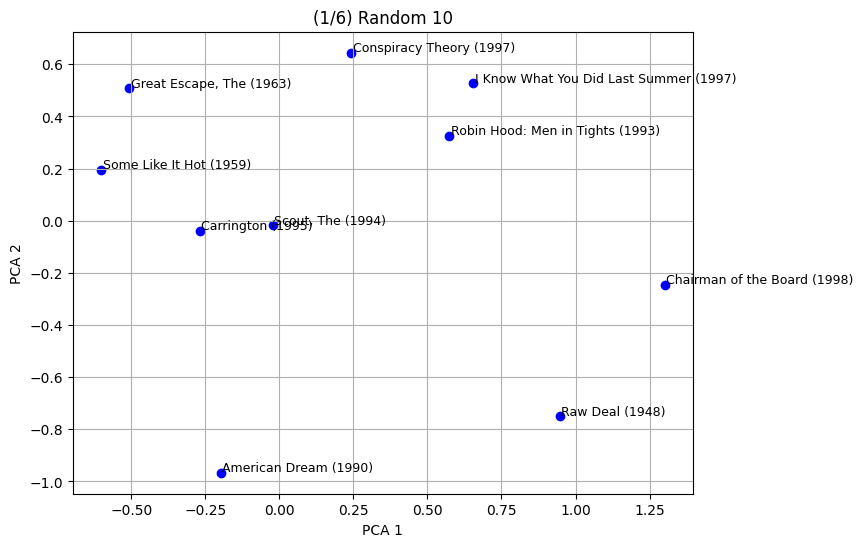

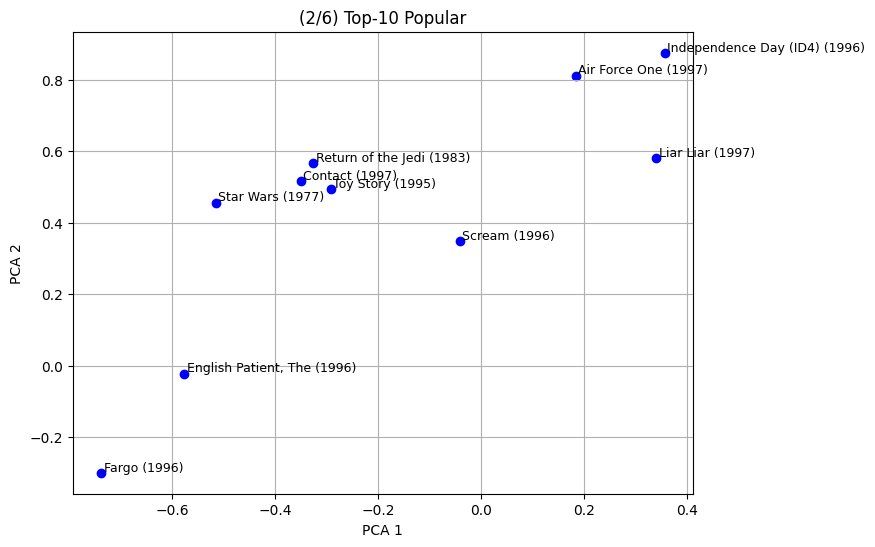

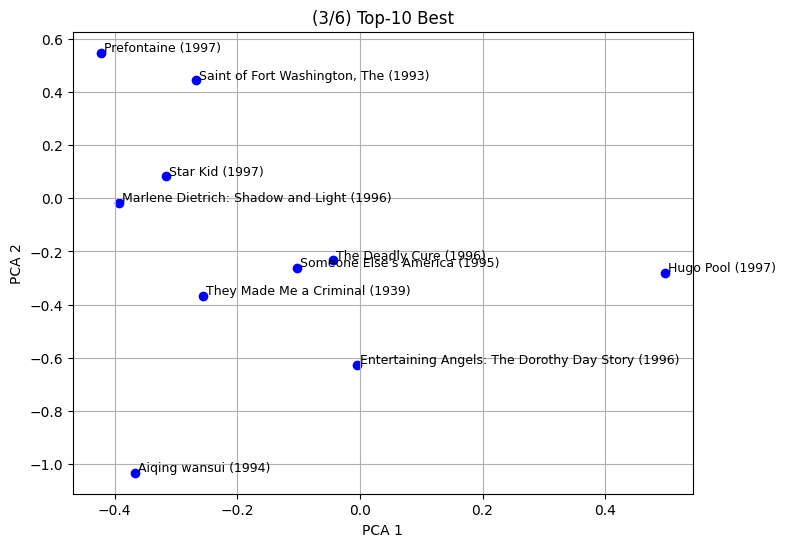

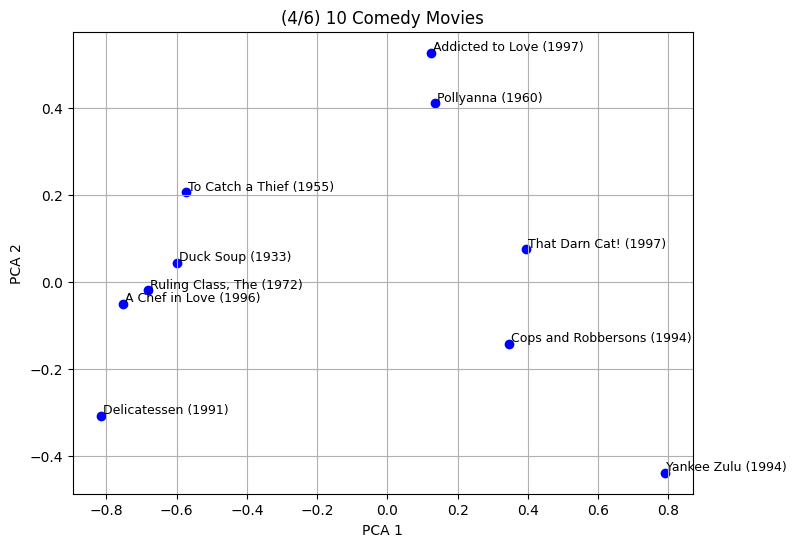

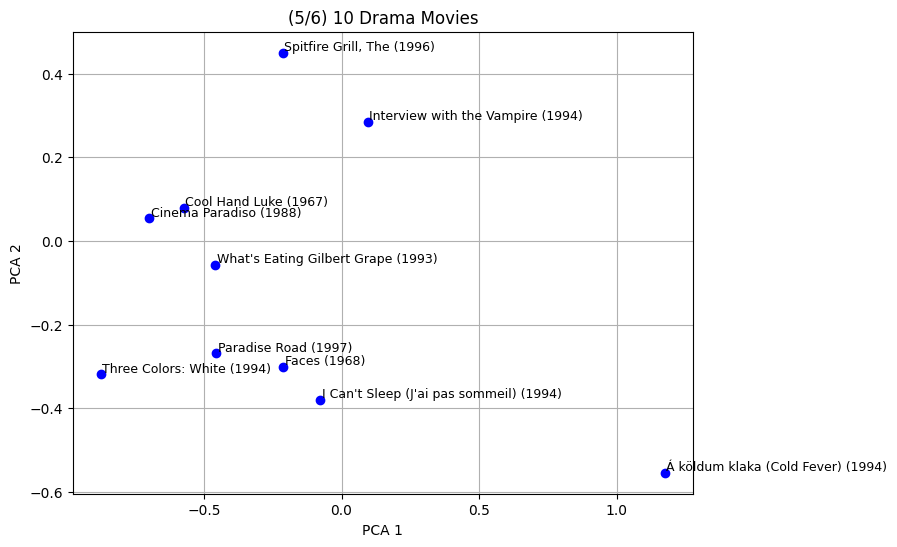

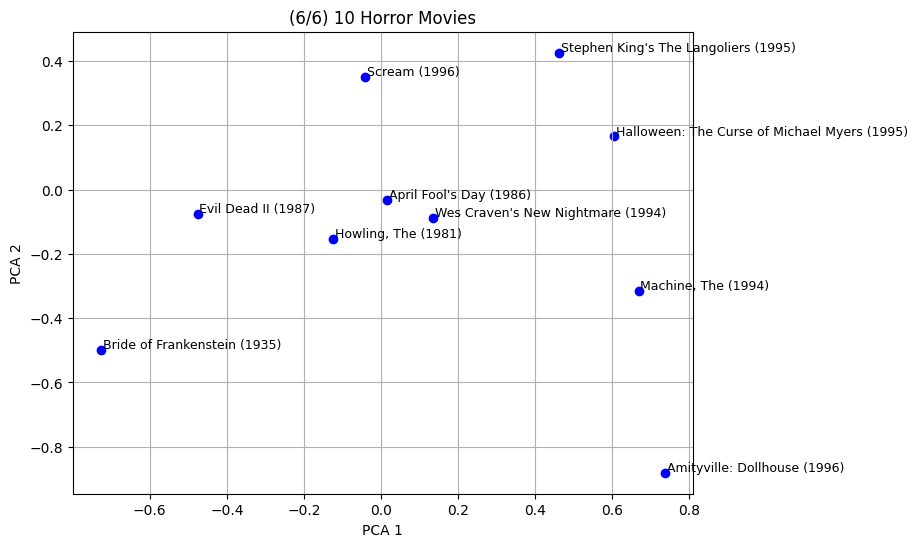

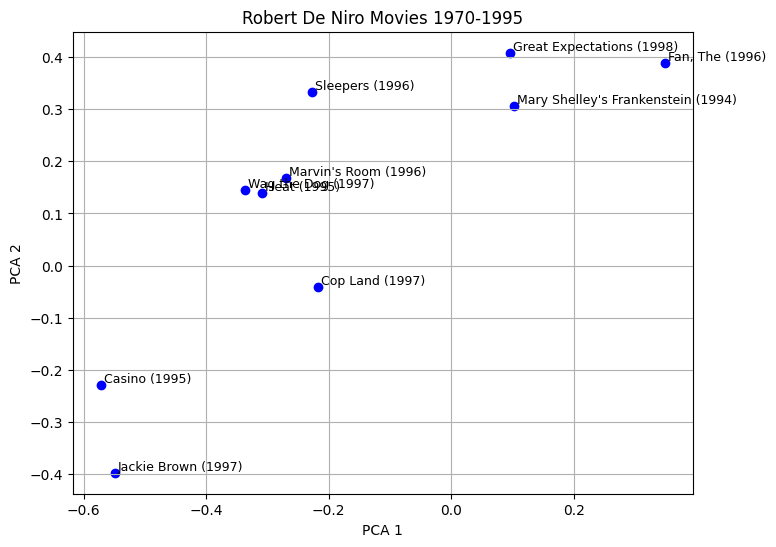

In [12]:
# V_final shape: (N, K)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
V_2d = pca.fit_transform(V_final)  # shape [N,2]

# build dict: movieID -> (x, y)
movieID_to_2d = {}
for movieID_1based in range(1, N+1):
    movieID_to_2d[movieID_1based] = V_2d[movieID_1based-1]

movies = pd.read_csv('movies.csv')
# rename columns if necessary
movie_titles = movies.set_index('Movie ID')['Movie Title'].to_dict()

def plot_movies_2d(movie_ids, title):
    plt.figure(figsize=(8,6))
    for mid in movie_ids:
        if mid in movieID_to_2d:
            x, y = movieID_to_2d[mid]
            plt.scatter(x, y, c='blue')
            label = movie_titles.get(mid, f"Movie {mid}")
            plt.text(x+0.005, y+0.005, label, fontsize=9)
    plt.title(title)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.grid(True)
    plt.show()

def top_n_movies(df, metric='count', n=10):
    grouped = df.groupby('movieID')['rating']
    if metric=='count':
        return grouped.size().sort_values(ascending=False).head(n).index.tolist()
    elif metric=='mean':
        return grouped.mean().sort_values(ascending=False).head(n).index.tolist()

# 6 graphs
train_df_unique = train_df.drop_duplicates(subset='movieID')
random_10 = train_df_unique['movieID'].sample(10).tolist()
plot_movies_2d(random_10, "(1/6) Random 10")

top10_pop = top_n_movies(train_df, 'count', 10)
plot_movies_2d(top10_pop, "(2/6) Top-10 Popular")

top10_best = top_n_movies(train_df, 'mean', 10)
plot_movies_2d(top10_best, "(3/6) Top-10 Best")

for (idx, genre) in enumerate(['Comedy','Drama','Horror'], start=4):
    subset_g = movies[movies[genre] == 1]['Movie ID']
    subset_g_10 = subset_g.sample(min(len(subset_g), 10)).tolist()
    plot_movies_2d(subset_g_10, f"({idx}/6) 10 {genre} Movies")

Robert_De_Niro_70_95_movies = [905, 347, 346, 327, 287, 628, 595, 693, 273, 561]
plot_movies_2d(Robert_De_Niro_70_95_movies, "Robert De Niro Movies 1970-1995")


In [60]:
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def get_err_with_bias(U, V, a, b, mu, Y, reg=0.0):
    """
    Compute the regularized MSE/2 cost for SVD-with-bias:
       pred_ij = mu + a[i] + b[j] + U[i]·V[j]
    Y is a list of (i, j, rating).
    """
    err = 0
    for (i, j, rating) in Y:
        r_pred = mu + a[i-1] + b[j-1] + np.dot(U[i-1], V[j-1])
        err += 0.5 * (rating - r_pred)**2
    
    # Regularize all parameters:
    # sum of squares of U, V, a, b
    err += 0.5 * reg * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2 + np.linalg.norm(a)**2 + np.linalg.norm(b)**2)
    return err / len(Y)

def grad_U_with_bias(Ui, Vi, a_i, b_j, mu, Yij, reg, eta):
    """
    Return how much to subtract from Ui (the gradient times step).
    We do the update:  Ui <- Ui - grad_U * step
    But for clarity, we define grad_U and multiply by step in this function.
    """
    # e_ij = Yij - (mu + a_i + b_j + Ui·Vi)
    # grad wrt Ui = - e_ij * Vi + reg * Ui
    # So the update is:  Ui <- Ui - eta * grad
    # We *return* the "update" that should be subtracted from Ui
    # => + eta * ( e_ij*Vi - reg*Ui )
    r_pred = mu + a_i + b_j + np.dot(Ui, Vi)
    e_ij = Yij - r_pred
    return eta * (reg * Ui - e_ij * Vi)

def grad_V_with_bias(Vj, Ui, a_i, b_j, mu, Yij, reg, eta):
    # same logic: e_ij = Yij - (mu + a_i + b_j + Ui·Vj)
    # grad wrt Vj = - e_ij * Ui + reg * Vj
    r_pred = mu + a_i + b_j + np.dot(Ui, Vj)
    e_ij = Yij - r_pred
    return eta * (reg * Vj - e_ij * Ui)

def train_model_with_bias(M, N, K, eta, reg, Y, max_epochs=100, eps=1e-4):
    """
    Biased SVD:
       rating_ij ~ mu + a[i] + b[j] + U[i]·V[j].
    M = #users, N = #items
    K = latent dimension
    eta = learning rate
    reg = regularization
    Y = list of (i, j, rating)
    returns (U, V, a, b, mu).
    """
    # Initialize
    U = np.random.uniform(-0.5, 0.5, size=(M, K))
    V = np.random.uniform(-0.5, 0.5, size=(N, K))
    a = np.zeros(M)  # user biases
    b = np.zeros(N)  # item biases

    # global average
    all_ratings = [rating for (_,_,rating) in Y]
    mu = np.mean(all_ratings)

    prev_err = get_err_with_bias(U, V, a, b, mu, Y, reg)
    reduction = 0

    for epoch in range(max_epochs):
        np.random.shuffle(Y)

        for (i, j, rating) in Y:
            r_pred = mu + a[i-1] + b[j-1] + np.dot(U[i-1], V[j-1])
            e_ij = rating - r_pred

            # Update user bias a[i-1], item bias b[j-1]
            # grad wrt a[i] = - e_ij + reg * a[i]
            # => update = eta*( e_ij - reg*a[i] )
            a[i-1] += eta * (e_ij - reg*a[i-1])
            b[j-1] += eta * (e_ij - reg*b[j-1])

            # Update U[i-1], V[j-1]
            Ui_update = grad_U_with_bias(U[i-1], V[j-1], a[i-1], b[j-1], mu, rating, reg, eta)
            Vj_update = grad_V_with_bias(V[j-1], U[i-1], a[i-1], b[j-1], mu, rating, reg, eta)
            U[i-1] -= Ui_update
            V[j-1] -= Vj_update

        curr_err = get_err_with_bias(U, V, a, b, mu, Y, reg)

        # Print progress every 10 epochs (optional)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train_err={curr_err:.4f}")

        if epoch == 0:
            reduction = prev_err - curr_err
        else:
            # if relative improvement is too small, break
            if ((prev_err - curr_err) / reduction) <= eps:
                break
        prev_err = curr_err

    return U, V, a, b, mu

In [61]:
def split_train_val(Y, val_ratio=0.2):
    random.shuffle(Y)
    cutoff = int(len(Y)*(1 - val_ratio))
    Y_train = Y[:cutoff]
    Y_val   = Y[cutoff:]
    return Y_train, Y_val

def grid_search_bias(M, N, K, Y_full, etas, regs, max_epochs=50):
    """
    Explore combinations of (eta, reg).
    We'll do a single 80-20 split for train/val, pick the best (eta, reg).
    """
    Y_train, Y_val = split_train_val(Y_full, 0.2)
    best_eta, best_reg = None, None
    best_val_err = float('inf')
    all_results = []

    for eta in etas:
        for reg in regs:
            print(f"\n*** Testing eta={eta}, reg={reg}")
            Utmp, Vtmp, atmp, btmp, mu_tmp = train_model_with_bias(
                M, N, K, eta, reg, Y_train, max_epochs
            )
            val_err = get_err_with_bias(Utmp, Vtmp, atmp, btmp, mu_tmp, Y_val, reg)
            print(f"Validation error = {val_err:.4f}")
            all_results.append((eta, reg, val_err))
            if val_err < best_val_err:
                best_val_err = val_err
                best_eta = eta
                best_reg = reg
    return best_eta, best_reg, best_val_err, all_results

In [62]:
df = pd.read_csv('train.csv')  # or whatever your main dataset is
df.rename(columns={'User ID':'userID','Movie ID':'movieID','Rating':'rating'}, inplace=True)
df['userID']  = df['userID'].astype(int)
df['movieID'] = df['movieID'].astype(int)
df['rating']  = df['rating'].astype(float)

M = df['userID'].max()
N = df['movieID'].max()

# Build Y
Y = []
for row in df.itertuples():
    Y.append((row.userID, row.movieID, row.rating))

K = 20
eta_candidates = [0.01, 0.03, 0.05, 0.07, 0.09] 
reg_candidates = [0.0, 0.05, 0.1, 0.15, 0.2]  

best_eta, best_reg, best_val_err, all_res = grid_search_bias(
    M, N, K, Y,
    etas=eta_candidates,
    regs=reg_candidates,
    max_epochs=50
)



*** Testing eta=0.01, reg=0.0
Epoch 0, train_err=0.4900
Epoch 10, train_err=0.2920
Epoch 20, train_err=0.2123
Epoch 30, train_err=0.1757
Epoch 40, train_err=0.1560
Validation error = 0.6532

*** Testing eta=0.01, reg=0.05
Epoch 0, train_err=0.4863
Epoch 10, train_err=0.3358
Epoch 20, train_err=0.2651
Epoch 30, train_err=0.2244
Epoch 40, train_err=0.2020
Validation error = 0.4781

*** Testing eta=0.01, reg=0.1
Epoch 0, train_err=0.4822
Epoch 10, train_err=0.3740
Epoch 20, train_err=0.3360
Epoch 30, train_err=0.3031
Epoch 40, train_err=0.2804
Validation error = 0.4401

*** Testing eta=0.01, reg=0.15
Epoch 0, train_err=0.4836
Epoch 10, train_err=0.3987
Epoch 20, train_err=0.3854
Epoch 30, train_err=0.3704
Epoch 40, train_err=0.3583
Validation error = 0.4374

*** Testing eta=0.01, reg=0.2
Epoch 0, train_err=0.4826
Epoch 10, train_err=0.4123
Epoch 20, train_err=0.4096
Epoch 30, train_err=0.4057
Epoch 40, train_err=0.4010
Validation error = 0.4468

*** Testing eta=0.03, reg=0.0
Epoch 0, tra

In [63]:
def create_pivot_table(data):
    # Convert data to a DataFrame
    df = pd.DataFrame(data, columns=['eta', 'reg', 'val_err'])
    
    # Ensure sorting of 'eta' and 'reg' values
    df = df.sort_values(by=['eta', 'reg'])

    # Create pivot table with 'eta' as index, 'reg' as columns, and 'val_err' as values
    pivot_table = df.pivot(index='eta', columns='reg', values='val_err')
    
    return pivot_table

pivot_table = create_pivot_table(all_res)
print(pivot_table)

print(f"\nBest (eta, reg) found: {best_eta}, {best_reg} with val err={best_val_err:.4f}")

reg       0.00      0.05      0.10      0.15      0.20
eta                                                   
0.01  0.653159  0.478076  0.440089  0.437402  0.446798
0.03  0.773678  0.483358  0.441875  0.441112  0.462268
0.05  0.730317  0.486209  0.446036  0.446009  0.464760
0.07  0.695537  0.479996  0.454254  0.459440  0.476092
0.09  0.704422  0.488449  0.461009  0.469323  0.481360

Best (eta, reg) found: 0.01, 0.15 with val err=0.4374


In [64]:
U_final, V_final, a_final, b_final, mu_final = train_model_with_bias(
    M, N, K, eta=best_eta, reg=best_reg, Y=Y, max_epochs=100
)
final_err = get_err_with_bias(U_final, V_final, a_final, b_final, mu_final, Y, best_reg)
print(f"Final training error with best hyperparams: {final_err:.4f}")

Epoch 0, train_err=0.4740
Epoch 10, train_err=0.4053
Epoch 20, train_err=0.3929
Epoch 30, train_err=0.3808
Epoch 40, train_err=0.3725
Epoch 50, train_err=0.3652
Epoch 60, train_err=0.3590
Final training error with best hyperparams: 0.3572


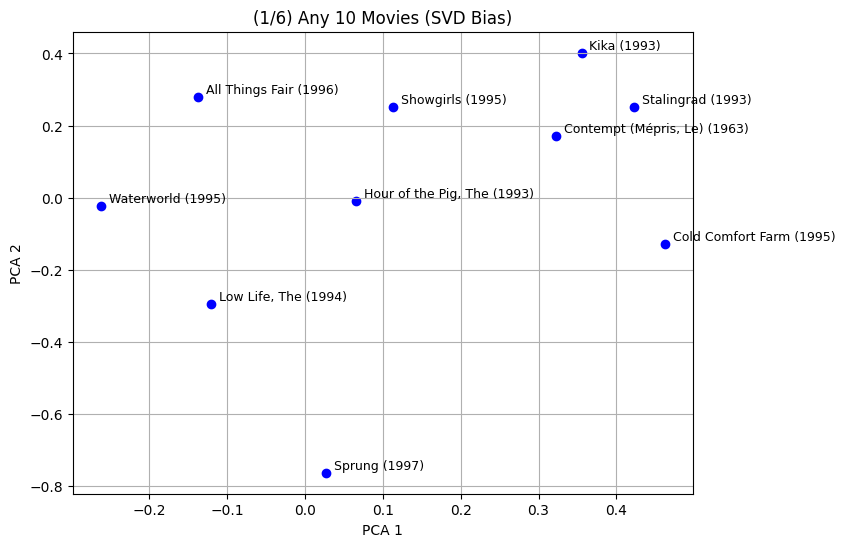

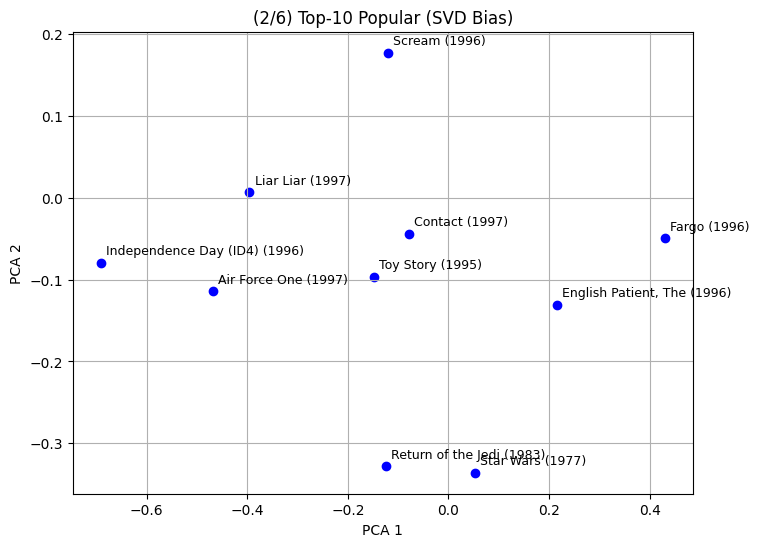

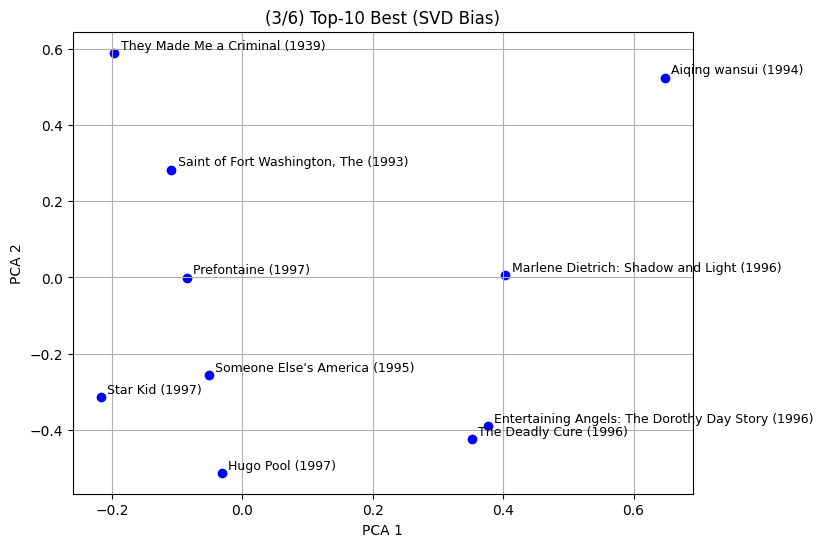

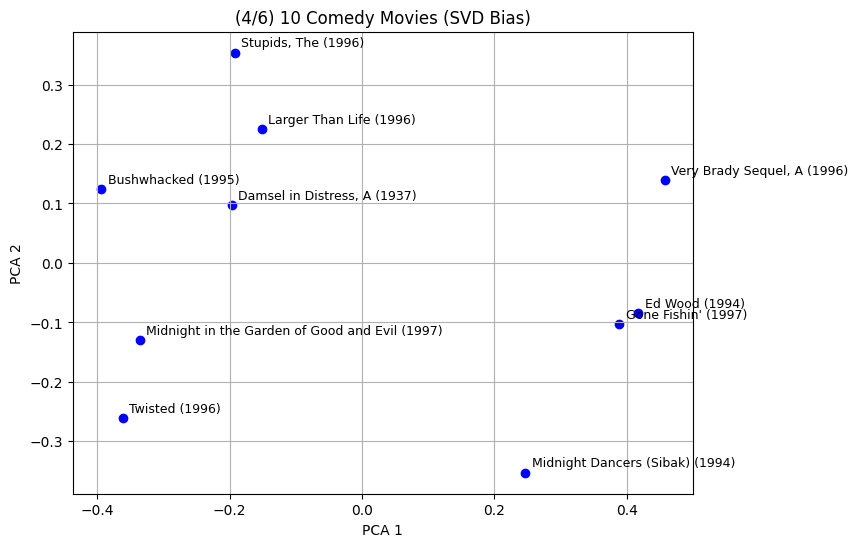

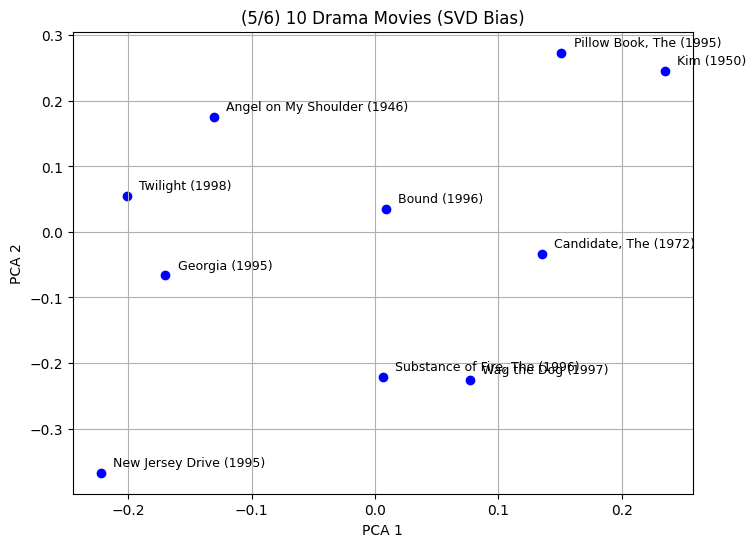

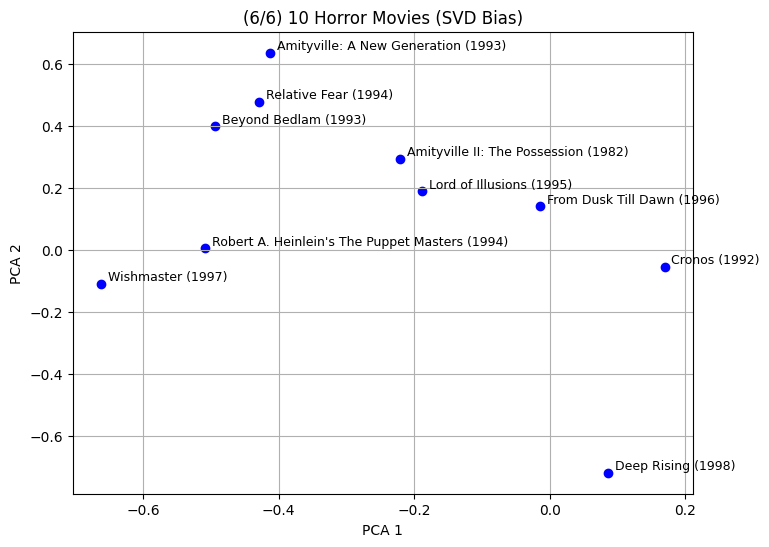


Done! Generated 6 plots for the Biased SVD model.


In [65]:
pca = PCA(n_components=2)
V_2d = pca.fit_transform(V_final)  # shape [N,2]

# movieID -> (x,y) in 2D
movieID_to_2d = {}
for movie_id_1based in range(1, N+1):
    movieID_to_2d[movie_id_1based] = V_2d[movie_id_1based-1]

# Load movies with genre info
movies = pd.read_csv('movies.csv')  # must have [MovieID, Movie Title, Comedy, Drama, Horror] or similar
if 'Movie ID' in movies.columns:
    movies.rename(columns={'Movie ID':'MovieID'}, inplace=True)

movie_titles = movies.set_index('MovieID')['Movie Title'].to_dict()

def plot_movies_2d(movie_ids, title):
    plt.figure(figsize=(8,6))
    for mid in movie_ids:
        if mid in movieID_to_2d:
            x, y = movieID_to_2d[mid]
            plt.scatter(x, y, color='blue')
            label = movie_titles.get(mid, f"Movie {mid}")
            plt.text(x+0.01, y+0.01, label, fontsize=9)
    plt.title(title)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.grid(True)
    plt.show()

def top_n_movies(df, metric='count', n=10):
    grouped = df.groupby('movieID')['rating']
    if metric=='count':
        return grouped.size().sort_values(ascending=False).head(n).index.tolist()
    elif metric=='mean':
        return grouped.mean().sort_values(ascending=False).head(n).index.tolist()

# (1) Any 10
random_10 = df['movieID'].drop_duplicates().sample(10).tolist()
plot_movies_2d(random_10, "(1/6) Any 10 Movies (SVD Bias)")

# (2) Top-10 Popular
top10_pop = top_n_movies(df, 'count', 10)
plot_movies_2d(top10_pop, "(2/6) Top-10 Popular (SVD Bias)")

# (3) Top-10 Best
top10_best = top_n_movies(df, 'mean', 10)
plot_movies_2d(top10_best, "(3/6) Top-10 Best (SVD Bias)")

# (4) 10 Comedy
if 'Comedy' in movies.columns:
    comedy_ids = movies[movies['Comedy']==1]['MovieID']
    sub_comedy = comedy_ids.sample(min(len(comedy_ids), 10)).tolist()
    plot_movies_2d(sub_comedy, "(4/6) 10 Comedy Movies (SVD Bias)")

# (5) 10 Drama
if 'Drama' in movies.columns:
    drama_ids = movies[movies['Drama']==1]['MovieID']
    sub_drama = drama_ids.sample(min(len(drama_ids), 10)).tolist()
    plot_movies_2d(sub_drama, "(5/6) 10 Drama Movies (SVD Bias)")

# (6) 10 Horror
if 'Horror' in movies.columns:
    horror_ids = movies[movies['Horror']==1]['MovieID']
    sub_horror = horror_ids.sample(min(len(horror_ids), 10)).tolist()
    plot_movies_2d(sub_horror, "(6/6) 10 Horror Movies (SVD Bias)")

print("\nDone! Generated 6 plots for the Biased SVD model.")

In [ ]:
!pip install surprise

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from sklearn.decomposition import PCA

In [ ]:
df = pd.read_csv('train.csv')
df.rename(columns={'User ID':'userID','Movie ID':'movieID','Rating':'rating'}, inplace=True)

df['userID']  = df['userID'].astype(int)
df['movieID'] = df['movieID'].astype(int)
df['rating']  = df['rating'].astype(float)

print(f"Loaded {len(df)} ratings from train.csv")
num_users = df['userID'].nunique()
num_items = df['movieID'].nunique()
print(f"{num_users} unique users, {num_items} unique items.")

In [ ]:
reader = Reader(rating_scale=(1,5))
full_data = Dataset.load_from_df(df[['userID','movieID','rating']], reader)

param_grid = {
    'n_factors': [20, 50],   # latent dimension K
    'n_epochs':  [20, 40],   # number of SGD iterations inside Surprise
    'lr_all':    [0.005, 0.01],  # learning rate
    'reg_all':   [0.02, 0.05]    # regularization for all parameters
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1, verbose=2)
gs.fit(full_data)

# Find best combination
best_params = gs.best_params['rmse']
print("\nBest Params (SVD) Based on 3-Fold CV:")
print(best_params)

In [ ]:
full_trainset = full_data.build_full_trainset()

best_svd = SVD(
    n_factors = best_params['n_factors'],
    n_epochs  = best_params['n_epochs'],
    lr_all    = best_params['lr_all'],
    reg_all   = best_params['reg_all']
)
best_svd.fit(full_trainset)

In [ ]:
K = best_params['n_factors']
max_movie_id = df['movieID'].max()

# Create a zero matrix of shape [K, max_movie_id]
Q_final = np.zeros((K, max_movie_id), dtype=np.float32)

# Fill in factors for the items that the Surprise trainset knows about
for inner_iid in range(full_trainset.n_items):
    raw_iid = full_trainset.to_raw_iid(inner_iid)  # actual movieID from the CSV
    # watch out for any potential off-by-ones or missing IDs
    if raw_iid <= max_movie_id:
        Q_final[:, raw_iid - 1] = best_svd.qi[inner_iid]

# Now Q_final is your item-factor matrix => shape (K, max_movie_id).
# We'll do PCA on Q_final.T => shape (max_movie_id, K)
item_factors = Q_final.T
pca = PCA(n_components=2)
item_factors_2d = pca.fit_transform(item_factors)  # shape (max_movie_id, 2)

# Build a dict: movieID -> (x, y)
movieID_to_2d = {}
for movieID_1based in range(1, max_movie_id+1):
    movieID_to_2d[movieID_1based] = item_factors_2d[movieID_1based - 1]

In [ ]:
movies = pd.read_csv('movies.csv')  # must have e.g. [MovieID, Movie Title, Comedy, Drama, Horror]
if 'Movie ID' in movies.columns:
    movies.rename(columns={'Movie ID':'MovieID'}, inplace=True)

movie_titles = movies.set_index('MovieID')['Movie Title'].to_dict()

def plot_movies_2d(movie_ids, title):
    plt.figure(figsize=(8,6))
    for mid in movie_ids:
        if mid in movieID_to_2d:
            x, y = movieID_to_2d[mid]
            plt.scatter(x, y, color='blue')
            label = movie_titles.get(mid, f"Movie {mid}")
            plt.text(x+0.01, y+0.01, label, fontsize=9)
    plt.title(title)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.grid(True)
    plt.show()

def top_n_movies(df, metric='count', n=10):
    grp = df.groupby('movieID')['rating']
    if metric == 'count':
        return grp.size().sort_values(ascending=False).head(n).index.tolist()
    elif metric == 'mean':
        return grp.mean().sort_values(ascending=False).head(n).index.tolist()

# (1) Any 10
random_10 = df['movieID'].drop_duplicates().sample(10).tolist()
plot_movies_2d(random_10, "(1/6) Any 10 Movies (Surprise SVD)")

# (2) Top-10 Popular
top10_popular = top_n_movies(df, 'count', 10)
plot_movies_2d(top10_popular, "(2/6) Top-10 Popular (Surprise SVD)")

# (3) Top-10 Best
top10_best = top_n_movies(df, 'mean', 10)
plot_movies_2d(top10_best, "(3/6) Top-10 Best (Surprise SVD)")

# (4) 10 Comedy
if 'Comedy' in movies.columns:
    comedy_ids = movies[movies['Comedy'] == 1]['MovieID']
    sub_comedy = comedy_ids.sample(min(len(comedy_ids), 10)).tolist()
    plot_movies_2d(sub_comedy, "(4/6) 10 Comedy Movies (Surprise SVD)")

# (5) 10 Drama
if 'Drama' in movies.columns:
    drama_ids = movies[movies['Drama'] == 1]['MovieID']
    sub_drama = drama_ids.sample(min(len(drama_ids), 10)).tolist()
    plot_movies_2d(sub_drama, "(5/6) 10 Drama Movies (Surprise SVD)")

# (6) 10 Horror
if 'Horror' in movies.columns:
    horror_ids = movies[movies['Horror'] == 1]['MovieID']
    sub_horror = horror_ids.sample(min(len(horror_ids), 10)).tolist()
    plot_movies_2d(sub_horror, "(6/6) 10 Horror Movies (Surprise SVD)")

print("\nDone! We produced 6 plots using the Off-the-Shelf SVD from Surprise.")